# TP RANSAC, homographie et mosaïque d'images aériennes

Guillaume Bourmaud

L'objectif de ce TP est d'**implémenter l'algorithme du RANSAC**. L'application considérée est la construction d'une mosaïque d'images aériennes. Ces images sont issues d'un drône capturant régulièrement des images du sol : 
Exemple image 1             |  Exemple image 2 |  Exemple image 3
:-------------------------:|:-------------------------:|:-------------------------:
![](images/01.jpg)  |  ![](images/02.jpg) |  ![](images/03.jpg)

L'archive contenant les images disponible [ici](https://gbourmaud.github.io/files/vision/TP/TP_mosaique_aerienne/images.zip).  
Dans ce TP, nous ferons l'hypothèse que le sol est un plan, permettant ainsi l'utilisation de la notion d'homographie.
  
  


## Mosaïque de deux images

Débutons par le cas d'une mosaïque de deux images $\mathbf{I}_A$ et $\mathbf{I}_B$. Nous allons implémenter les étapes suivantes :
1. Mise en correspondance de $\mathbf{I}_A$ et $\mathbf{I}_B$ en utilisant des fonctions d'OpenCV
2. Estimation de l'homographie $\mathbf{H}_{AB}$ en **implémentant un RANSAC + DLT**. Remarque : l'algorithme DLT a été implémenté lors du [TP de rectification homographique](https://github.com/gbourmaud/gbourmaud.github.io/blob/master/files/vision/TP/TP_rectification_homographique/rectification_homographique.ipynb), vous pouvez donc récupérer votre code pour gagner du temps.
3. Utiliser $\mathbf{H}_{AB}$ pour créer une mosaïque dans le plan image de $\mathbf{I}_A$. Voici le résultat recherché :  
![im](mosaic_2_im.png)  
Pour obtenir ce résultat, l'image $\mathbf{I}_A$ et l'image $\mathbf{I}_B$ transformée ont été moyennées, ce qui permet de faire ressortir la zone de chevauchement des deux images.






### Mise en correspondance de $\mathbf{I}_A$ et $\mathbf{I}_B$ en utilisant des fonctions d'OpenCV
L'objectif de ce TP n'est pas d'implémenter d'algorithme de mise en correspondance. Par conséquent, nous allons simplement utiliser l'implémentation SIFT disponible dans OpenCV. Afin de gagner du temps, vous trouverez le code ci-après :

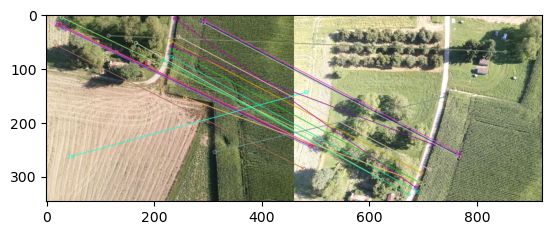

In [1]:
from PIL import Image
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

I_A = np.array(Image.open('images/01.jpg'))
I_B = np.array(Image.open('images/03.jpg'))

I_A_float = I_A.astype(float)/255.
I_B_float = I_B.astype(float)/255.

I_A_grey = ((I_A_float.sum(axis=2)/3)*255).astype(np.uint8)
I_B_grey = ((I_B_float.sum(axis=2)/3)*255).astype(np.uint8)

# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kpA, desA = sift.detectAndCompute(I_A_grey,None)
pts_A = cv.KeyPoint_convert(kpA)
kpB, desB = sift.detectAndCompute(I_B_grey,None)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(desA,desB,k=2)
# Apply ratio test
good = []
for m,n in matches:
 if m.distance < 0.75*n.distance:
     good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
fig1, ax1 = plt.subplots(1)
ax1.imshow(cv.drawMatchesKnn(I_A,kpA,I_B,kpB,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
plt.pause(0.01)

nMatches = len(good)
p_A = np.float32([kpA[m[0].queryIdx].pt for m in good])
p_A_hom = np.ones((nMatches,3))
p_A_hom[:,:2] = p_A
p_B = np.float32([kpB[m[0].trainIdx].pt for m in good])
p_B_hom = np.ones((nMatches,3))
p_B_hom[:,:2] = p_B

Vous pouvez visuellement vérifier que certaines correspondances sont correctes, alors que d'autres sont clairement erronées. Ce code produit deux `np.array` de coordonnées de correspondances (en coordonnées homogènes) : `p_A_hom` et `p_B_hom`. Par exemple, la première ligne de `p_A_hom` (`p_A_hom[0,:]`) est une coordonnée dans $\mathbf{I}_A$, et son correspondant dans $\mathbf{I}_B$ est stocké dans la première ligne de `p_B_hom` (`p_B_hom[0,:]`).   

### Estimation de l'homographie $\mathbf{H}_{AB}$ en **implémentant un RANSAC + DLT**

À partir des correspondances précédemment établies $\{(\underline{\mathbf{p}}_{A,i},\underline{\mathbf{p}}_{B,i})\}_{i=1...N_{\text{matches}}}$, votre travail consiste à implémenter un RANSAC + DLT dans le but d'estimer l'homographie $\mathbf{H}_{AB}$.  

**CORRECTION** : Vous trouverez ci-après un exemple d'implémentation d'un RANSAC+DLT à laquelle vous pourrez vous référer si vous êtes bloqués.

Iteration 0 : 4 inliers
Iteration 5 : 8 inliers
Iteration 32 : 10 inliers
Iteration 41 : 12 inliers


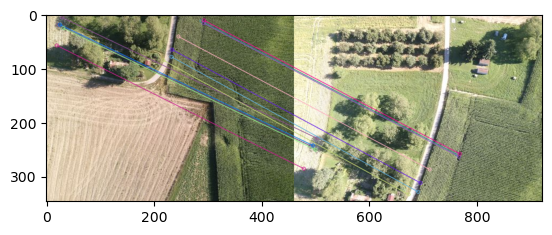

In [5]:
def DLT(p_A, p_B):
    p_A_vec = p_A.ravel(order='F')
    M = np.zeros((8,8))
    
    for i in range(4):
        pBx = p_B[0,i]
        pBy = p_B[1,i]
        pAx = p_A[0,i]
        pAy = p_A[1,i]
        
        M_line_1 = [pBx, 0, -pBx*pAx, pBy, 0, -pBy*pAx, 1, 0]
        M_line_2 = [0, pBx, -pBx*pAy, 0, pBy, -pBy*pAy, 0, 1]
        
        M[i*2:(i+1)*2,:] = np.array([M_line_1, M_line_2])
    
    
    
    h = np.linalg.solve(M.T.dot(M), M.T.dot(p_A_vec))
    
    H_AB = np.array([[h[0], h[3], h[6]], [h[1], h[4], h[7]], [h[2], h[5], 1]])
    return H_AB


nIt = 500
thresh = 1.5 #pix

nInliers_best = 0
for it in range (nIt):
    
    #Sample 4 matches
    rng = np.random.default_rng()
    ids = rng.choice(nMatches, size=4, replace=False)
    
    p_A_sel = p_A[ids,:]
    p_B_sel = p_B[ids,:]
    
    #Estimate homography
    H_AB = DLT(p_A_sel.T, p_B_sel.T)
    #H_AB, mask = cv.findHomography(p_B_sel, p_A_sel)

    #Compute cost
    p_A_pred = (temp := p_B_hom.dot(H_AB.T)) / temp[:, 2:3]
    mask_inliers = ((p_A_hom - p_A_pred)**2).sum(axis=1) < thresh**2
    nInliers = mask_inliers.sum()
    
    if(nInliers_best<nInliers):
        nInliers_best = nInliers
        H_AB_best = H_AB
        mask_inliers_best = mask_inliers
        print('Iteration {} : {} inliers'.format(it,nInliers_best))

inlier_matches = [good[idx] for idx in np.nonzero(mask_inliers_best)[0]]
fig2, ax2 = plt.subplots(1)
ax2.imshow(cv.drawMatchesKnn(I_A,kpA,I_B,kpB,inlier_matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
plt.pause(0.01)

###  Utilisation de $\mathbf{H}_{AB}$ pour créer une mosaïque dans le plan image de $\mathbf{I}_A$

Afin de créer une mosaïque dans le plan image de $\mathbf{I}_A$, il va d'abord falloir définir la taille de cette mosaïque.  
**Faire un schéma** du résultat souhaité, en faisant figurer les 4 coins $\mathbf{I}_A$, les 4 coins de $\mathbf{I}_B$ dans le plan image de $\mathbf{I}_A$. Tracer les bornes de la mosaïque et déduisez-en la taille de cette dernière.  
**CORRECTION** : Vous trouverez ci-après un exemple de calcul de la taille de la mosaïque.

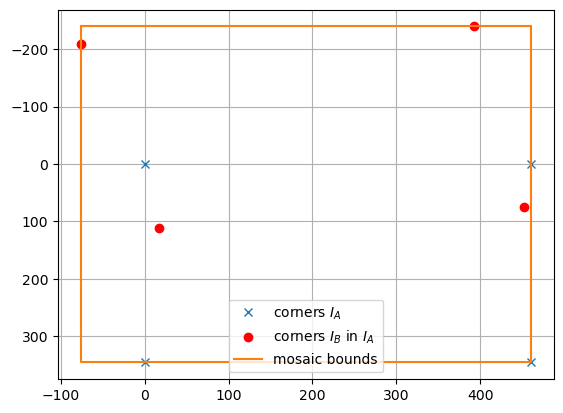

In [7]:
#Compute bounds
hA, wA, _ = I_A.shape
corners_IA = np.array([[0, wA, wA, 0], [0, 0, hA, hA], [1, 1, 1, 1]]).T
hB, wB, _ = I_A.shape
corners_IB = np.array([[0, wB, wB, 0], [0, 0, hB, hB], [1, 1, 1, 1]]).T
corners_IB_in_IA = (temp := corners_IB.dot(H_AB_best.T)) / temp[:, 2:3]

minx = min([min(corners_IA[:,0]),min(corners_IB_in_IA[:,0])])
maxx = max([max(corners_IA[:,0]),max(corners_IB_in_IA[:,0])])
miny = min([min(corners_IA[:,1]),min(corners_IB_in_IA[:,1])])
maxy = max([max(corners_IA[:,1]),max(corners_IB_in_IA[:,1])])

fig4, axs4 = plt.subplots(1)
axs4.plot(corners_IA[:,0],corners_IA[:,1],'x',label='corners $I_A$')
axs4.plot(corners_IB_in_IA[:,0],corners_IB_in_IA[:,1],'or',label='corners $I_B$ in $I_A$')
axs4.plot([minx, maxx, maxx, minx, minx],[miny, miny, maxy, maxy, miny],label='mosaic bounds')
axs4.grid(True)
axs4.invert_yaxis()
axs4.legend()

w_mosaic = int(maxx - minx + 1)
h_mosaic = int(maxy - miny + 1)

Maintenant que les bornes et la taille de la mosaïque sont connues, il va falloir créer la mosaïque. 

Quelle transformation faut-il appliquer à $\mathbf{I}_A$ pour la placer au bon endroit dans la mosaïque ? Écrire cette transformation sous la forme d'une matrice d'homographie $\mathbf{H}_{AM}$ qui transforme un point de la mosaïque en un point de  $\mathbf{I}_A$. **Indice** : Où doit se situer l'origine de  $\mathbf{I}_A$ dans la mosaïque ?
Appliquer $\mathbf{H}_{AM}$ à $\mathbf{I}_A$. Visualiser le résultat.

La transformation à appliquer à $\mathbf{I}_B$ est l'homographie $\mathbf{H}_{BM}=\mathbf{H}_{BA}\mathbf{H}_{AM}$. Appliquer cette transformation et visualiser le résultat.  

Combiner les deux images précédentes (par exemple en faisant une moyenne) pour obtenir une mosaïque.  

**CORRECTION** : Vous trouverez ci-après un exemple de création de mosaïque.

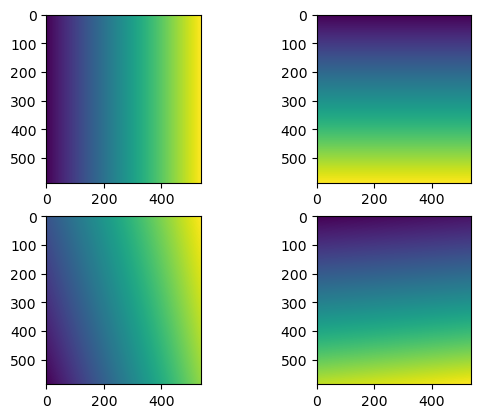

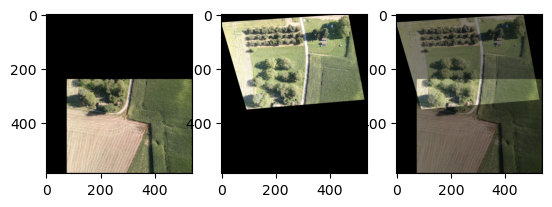

In [8]:
def getInterpolationGrids(Hij, h_j, w_j):

    x = np.arange(0,w_j)
    y = np.arange(0,h_j)
    X, Y = np.meshgrid(x,y) #h_j x w_j
    
    p_j = np.ones((h_j,w_j,3)) #h_j x w_j x 3
    p_j[:,:,0] = X
    p_j[:,:,1] = Y
        
    p_i = (temp := p_j @ (Hij.T)) / temp[:,:,2:3] #h_j x w_j x 3


    XI = p_i[:,:,0] #h_j x w_j
    YI = p_i[:,:,1] #h_j x w_j
 

    return XI, YI

H_MA = np.array([[1., 0., -minx], [0., 1., -miny], [0, 0, 1]]) #the origin of I_A has coordinates -minx,-miny in the mosaic
H_AM = np.array([[1., 0., minx], [0., 1., miny], [0, 0, 1]])
XI_A, YI_A = getInterpolationGrids(H_AM, h_mosaic, w_mosaic)
I_mosA = cv.remap(I_A_float.astype(np.float32), XI_A.astype(np.float32), YI_A.astype(np.float32), cv.INTER_LINEAR) #very fast but inaccurate

fig5, axs5 = plt.subplots(2,2)
axs5[0,0].imshow(XI_A)
axs5[0,1].imshow(YI_A)

H_BM = np.linalg.inv(H_AB_best) @ H_AM
XI_B, YI_B = getInterpolationGrids(H_BM, h_mosaic, w_mosaic)
I_mosB = cv.remap(I_B_float.astype(np.float32), XI_B.astype(np.float32), YI_B.astype(np.float32), cv.INTER_LINEAR) #very fast but inaccurate

axs5[1,0].imshow(XI_B)
axs5[1,1].imshow(YI_B)

fig6, axs6 = plt.subplots(1,3)
axs6[0].imshow(I_mosA)
axs6[1].imshow(I_mosB)
axs6[2].imshow(0.5*(I_mosA + I_mosB))

Image.fromarray((0.5*(I_mosA + I_mosB)*255).astype(np.uint8)).save("mosaic_2_im.png")

## Mosaïque de dix images

Généraliser le code ayant permis d'obtenir une mosaïque de deux images afin d'obtenir une mosaïque de dix images.

![im](result_mosaique_all_images.png)
